# LangGraph Development Notebook

This notebook is set up for developing and testing LangGraph components. It includes:
- Environment setup
- Basic graph structure
- Example nodes and tools
- Testing cells

In [65]:
# Import required packages
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI

# Load environment variables
load_dotenv()

# Initialize the LLM
llm = ChatOpenAI(temperature=0)

## Define tools

Define your custom tools here. Each tool should be a function with type hints.

In [66]:
from typing import Optional, Any, Dict
from tavily import TavilyClient

def tavily_custom_search(query: str, include_answer: Optional[str] = None) -> Dict[Any, Any]:
    """
    Custom Tavily search tool that allows direct configuration of the search.
    
    Args:
        query: The search query
        search_type: Type of search ("search", "answer", or "advanced")
        
    Returns:
        Dict containing search results
    """
    client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    
    # Build search parameters
    search_params = {
        "query": query,
        "search_depth": "advanced",
        "max_results": 10,
    }
    
    # Only add include_answer if it's provided
    if include_answer is not None:
        search_params["include_answer"] = include_answer
    
    response = client.search(**search_params)
    
    return response



## Test custom search tool

### Biography

In [67]:
result = tavily_custom_search(query="Asaf Yuria Quartet biography", include_answer="advanced")
print("\n\nAdvanced answer")
print(result["answer"])

result = tavily_custom_search(query="Asaf Yuria Quartet biography", include_answer="basic")
print("\n\nBasic answer")
print(result["answer"])




Advanced answer
Asaf Yuria is an Israeli-born saxophonist and composer based in New York City. Born in Tel Aviv in 1985, he began playing saxophone at age nine and was performing in local Tel Aviv clubs while still a teenager. Yuria graduated with honors from the prestigious New School for Jazz and Contemporary Music in 2012, where he studied under mentors like Billy Harper, George Cables, and Reggie Workman. He has been a key member of renowned bassist Omer Avital's quintet for several years and released his debut album "Papa Wawa" in 2018. Yuria has performed with notable musicians such as Jimmy Cobb and Kirk Lightsey, and leads his own quartet which has played at venues like Smalls Jazz Club in New York. His music is influenced by jazz greats like John Coltrane and Charlie Parker, and he is considered one of the leading young voices on the New York jazz scene.


Basic answer
Asaf Yuria is a saxophonist born in 1985, known for his work with the Asaf Yuria Quartet and collaborations

### Official website

In [68]:
result = tavily_custom_search(query="Asaf Yuria Quartet official website -- include url", include_answer="basic")
print("\n\nBasic answer")
print(result["answer"])



Basic answer
The official website for Asaf Yuria Quartet is https://www.asafyuria.com/. This site includes information about his music and performances.


### Instagram

In [69]:
result = tavily_custom_search(query="Asaf Yuria Quartet official instagram handle -- include instagram handle and url", include_answer="basic")
print("\n\nBasic answer")
print(result["answer"])



Basic answer
Asaf Yuria Quartet's official Instagram handle is @asafyuria. The URL is https://www.instagram.com/asafyuria/.


### Youtube

In [70]:
result = tavily_custom_search(query="Asaf Yuria Quartet performance youtube videos")
print([result["url"] for result in result["results"] if result["url"].startswith("https://www.youtube.com")])

['https://www.youtube.com/watch?v=XrpKLTsYtAc', 'https://www.youtube.com/watch?v=751brqsgHUY', 'https://www.youtube.com/watch?v=ewxrkaH6cFI', 'https://www.youtube.com/user/fuzzfuzzify', 'https://www.youtube.com/watch?v=UXBKZgD14n4', 'https://www.youtube.com/watch?v=z76a-0QSRyk', 'https://www.youtube.com/watch?v=jD3uE6pG0ho', 'https://www.youtube.com/watch?v=sA8mtTeT4UM', 'https://www.youtube.com/watch?v=p2dDsAZJ6XA']


## Define custom state object

Define custom state object for artist profile.

In [71]:
from typing import List, Optional
from langchain_core.messages import BaseMessage
from dataclasses import dataclass

@dataclass
class ArtistState:
    artist_name: str
    messages: List[BaseMessage]
    website: Optional[str] = None
    instagram: Optional[str] = None
    youtube_urls: List[str] = None
    biography: Optional[str] = None

    def __str__(self) -> str:
        return f"""
Artist: {self.artist_name}
Website: {self.website or 'Not found'}
Instagram: {self.instagram or 'Not found'}
YouTube URLs: {', '.join(self.youtube_urls) if self.youtube_urls else 'None'}
Biography: {'Found' if self.biography else 'Not found'}
Messages: {len(self.messages)} messages in conversation
"""


## Define nodes

Define nodes for various aspects of the artist's profile.

In [96]:
from langchain_core.messages import AIMessage

def generate_bio(state: ArtistState):
    result = tavily_custom_search(query=f"{state.artist_name} biography", 
                                  include_answer="advanced")
    new_biography = result["answer"]

    new_message = f"I generated this biography:\n\n{new_biography}"

    # Return a NEW state object
    return ArtistState(
        artist_name=state.artist_name,
        messages=state.messages + [AIMessage(content=new_message)],
        website=state.website,
        instagram=state.instagram,
        youtube_urls=state.youtube_urls,
        biography=new_biography
    )

def find_website(state: ArtistState):
    result = tavily_custom_search(query=f"{state.artist_name} official website -- include url", 
                                  include_answer="basic")
    website_anwer = result["answer"]

    new_message = f"I found this answer to my website search:\n\n{website_anwer}"
    all_messages = state.messages + [AIMessage(content=new_message)]

    import re
    url_pattern = re.compile(r'https?://(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b[-a-zA-Z0-9()@:%_\+.~#?&//=]*')
    url_match = url_pattern.search(website_anwer)
    website = url_match.group(0).rstrip(".") if url_match else None
    new_message = f"I extracted this website from the answer:\n\n{website}"
    all_messages = all_messages + [AIMessage(content=new_message)]

    # Return a NEW state object
    return ArtistState(
        artist_name=state.artist_name,
        messages=all_messages,
        website=website,
        instagram=state.instagram,
        youtube_urls=state.youtube_urls,
        biography=state.biography
    )

def find_instagram(state: ArtistState):
    result = tavily_custom_search(query=f"{state.artist_name} official instagram handle -- include instagram handle and url", include_answer="basic")
    instagram_answer = result["answer"]

    new_message = f"I found this answer to my instagram search:\n\n{instagram_answer}"
    all_messages = state.messages + [AIMessage(content=new_message)]

    import re
    url_pattern = re.compile(r'https?://(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b[-a-zA-Z0-9()@:%_\+.~#?&//=]*')
    url_match = url_pattern.search(instagram_answer)
    instagram = url_match.group(0).rstrip(".") if url_match else None
    new_message = f"I extracted this instagram from the answer:\n\n{instagram}"
    all_messages = all_messages + [AIMessage(content=new_message)]

    # Return a NEW state object
    return ArtistState(
        artist_name=state.artist_name,
        messages=all_messages,
        website=state.website,
        instagram=instagram,
        youtube_urls=state.youtube_urls,
        biography=state.biography
    )

def find_youtube_videos(state: ArtistState):
    result = tavily_custom_search(query=f"{state.artist_name} performance youtube videos")
    youtube_videos = [search_result["url"] for search_result in result["results"] \
                      if search_result["url"].startswith("https://www.youtube.com")]

    new_message = f"I found {len(youtube_videos)} youtube videos for {state.artist_name}"
    
    if len(youtube_videos) > 0:
        video_urls_message = ', '.join(youtube_videos)
        new_message = new_message + "\n\n" + video_urls_message

    all_messages = state.messages + [AIMessage(content=new_message)]
        

    # Return a NEW state object
    return ArtistState(
        artist_name=state.artist_name,
        messages=all_messages,
        website=state.website,
        instagram=state.instagram,
        youtube_urls=youtube_videos,
        biography=state.biography
    )

## Create graph structure

Define your graph structure and nodes here.

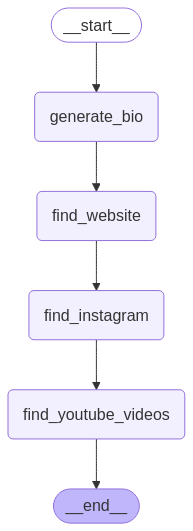

In [97]:

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(ArtistState)
builder.add_node("generate_bio", generate_bio)
builder.add_node("find_website", find_website)
builder.add_node("find_instagram", find_instagram)
builder.add_node("find_youtube_videos", find_youtube_videos)

builder.add_edge(START, "generate_bio")
builder.add_edge("generate_bio", "find_website")
builder.add_edge("find_website", "find_instagram")
builder.add_edge("find_instagram", "find_youtube_videos")
builder.add_edge("find_youtube_videos", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Test the Graph

Test your graph with different inputs and see the results.

In [98]:
from langchain_core.messages import HumanMessage

artist_name = "Asaf Yuria Quartet"

# init artist state
init_artist_state = ArtistState(
    artist_name=artist_name,
    messages=[HumanMessage(content=artist_name)])

# Get result from graph
result = graph.invoke(init_artist_state)

# Access messages (using dictionary access since it's an AddableValuesDict)
for message in result["messages"]:
    message.pretty_print()

artist_state_complete = ArtistState(**result)

# Access the website
print("\n\n")
print(artist_state_complete)


================================ Human Message =================================

Asaf Yuria Quartet
================================== Ai Message ==================================

I generated this biography:

Asaf Yuria is an Israeli saxophonist and composer born in Tel Aviv in 1985. He began playing saxophone at age nine and performed in local Tel Aviv clubs as a teenager before moving to New York City to pursue his jazz career. Yuria graduated with honors from the New School for Jazz and Contemporary Music, where he studied under mentors like Billy Harper, George Cables, and Reggie Workman. He has been an integral part of bassist Omer Avital's quintet for several years and released his debut album "Papa Wawa" in 2018. Yuria's sophomore album "Exorcisms" came out in 2021, featuring a lineup of top New York jazz musicians. He continues to perform regularly, including with his quartet at venues like Smalls Jazz Club in New York City, showcasing his inventive horn arrangements and cap

## Debugging Tips

1. Use `%%debug` magic command for step-by-step debugging
2. Print intermediate states
3. Test individual components separately